In [16]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from time import perf_counter_ns
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import train_test_split,GroupKFold,GroupShuffleSplit,cross_validate
from sklearn.metrics import precision_score, accuracy_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve,classification_report
import xgboost as xgb

In [17]:
# list of user ID for file name generation
user_ids=[ "{:02d}".format(i) for i in range(51) ]
str_sensors=['accel','gyro']
str_instrs=['phone','watch'] 

In [59]:
CONVERT={'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,
    'L':11,'M':12,'O':13,'P':14,'Q':15,'R':16,'S':17}

def act_conv(X):
    return CONVERT[X]

def t_conv(time):
    '''convert time from ns to ms
    '''
    return int(time)//1_000_000

def parse_rawfile(instr,sensor,user_id,user_data):    
    '''Parse a raw text file and get sensor data. For accelmeter, convert to spherical coordinate
    '''
    filename='data/raw/'+instr+'/'+sensor+'/data_16{}_'+sensor+'_'+instr+'.txt'
    user_file=filename.format(user_id)
    name_x=instr+sensor+'_x'
    name_y=instr+sensor+'_y'
    name_z=instr+sensor+'_z'
    data=pd.read_csv(user_file,names=['user_id','act_id','time',name_x,name_y,name_z],sep='[,;]',
            engine='python', dtype={'user_id':'str',name_x:np.float32,name_y:np.float32,name_z:np.float32},              
            converters={'act_id':act_conv,'time':t_conv},index_col=False)
    
    if sensor == 'accel':
        name_r=instr+'_r'
        name_phi=instr+'_phi'
        name_theta=instr+'_theta'
        #For accelmeter, conversion from cartesian to spherical coordinates:
        
        data[name_r]=np.sqrt(data[name_x]**2 + data[name_y]**2 + data[name_z]**2)
        data[name_phi]=np.arctan2(data[name_y],data[name_z])
        data[name_theta]=np.arccos(data[name_z]/data[name_r])
        
    data_name=instr+'_'+sensor
    if user_id in user_data:
        user_data[user_id][data_name]= data
    else:    
        user_data[user_id] = {data_name:data}

In [ ]:
#for each user, generate a dataframe containing all the data.
#the test set will be a set of randomly selected users, while the remaining users
#will form the training set. 
#for user_id in user_ids:
def parse_allfile(user_data):
    for user_id in user_ids:
        for i in range(2):
            for j in range(2):
                parse_rawfile(str_instrs[i],str_sensors[j],user_id,user_data)
        print(user_id)

In [34]:
#user_data={}
#parse_allfile(user_data)
#pickle.dump(user_data,open('user_data.p','wb'))
user_data=pickle.load(open('user_data.p','rb'))

In [125]:
MAX_COEFF=2
MIN_COUNT=30
def fftcoeff(x):
    size=len(x)
    if size <  MIN_COUNT:
        return 0
    data=np.fft.rfft(x)/size
#    return ( data[0].real, abs(data[1].real))
#            +abs(data[2].real), abs(data[4].real)+abs(data[5].real))
    return ( data[0].real, 
#            abs(data[13].real)+abs(data[14].real)+abs(data[15].real), 
#            abs(data[size//4-1].real)+abs(data[size//4-2].real)+abs(data[size//4-3].real),
            abs(data[-1].real)+abs(data[-2].real)+abs(data[-3].real))
#    return (data[0].real, abs(data[3].real)+abs(data[4].real)+abs(data[5].real)+abs(data[6].real)+abs(data[2].real), abs(data[11].real)+abs(data[12].real)+abs(data[13].real)+abs(data[14].real)+abs(data[10].real), 
#            abs(data[19].real)+abs(data[20].real)+abs(data[21].real)+abs(data[22].real)+abs(data[18].real), abs(data[27].real)+abs(data[28].real)+abs(data[29].real)+abs(data[30].real)+abs(data[26].real) )

def gen_feature(instr,sensor,user_id,user_data,over_lap=1,interval=4000): 
    
    '''merge data from different sensors together to form a sample
    Use  "interval" ms to aggregate data  
    '''
    data_name=instr+'_'+sensor
    name_x=instr+sensor+'_x'
    name_y=instr+sensor+'_y'
    name_z=instr+sensor+'_z'
    
    data=user_data[user_id][data_name]
    features = ['std','min','max',fftcoeff]
    
#    features = ['std','min','max',fftcoeff]
    feature_dict={'user_id':'count',name_x:features, name_y: features, name_z:features}
    
    name_list=[name_x,name_y,name_z]
    data['dtime']=data.groupby(['act_id'])['time'].transform('min')
    
    if sensor == 'accel':
        name_r=instr+'_r'
        name_phi=instr+'_phi'
        name_theta=instr+'_theta'
        name_list = [name_x,name_y,name_z,name_r,name_phi,name_theta]
 
        feature_dict[name_r] = features
        feature_dict[name_phi] = features
        feature_dict[name_theta] = features    
        
    #form a bin for data in non-overlapping interval ms.
    data_feature=[]
    for i in range(over_lap):        
        data['bin']=200*i + (data['time']-i*interval-data['dtime'])//(interval*over_lap)        
            
        #time in phone and watch are different.
        data1=data.groupby(['act_id','bin']).agg(feature_dict)  
    
#    min_count = 0.4 * np.mean(data_feature[('user_id','count')])
        min_count=interval*over_lap//100
    #drop rows with less than 40% of the sample points of other rows    
        empty_index=data1[ data1[('user_id','count')] < min_count].index                        
        data1.drop(empty_index,inplace=True)
        
        size=len(name_list) 
        coeff=np.zeros((len(data1),size*MAX_COEFF))
        start=0
        final_name=[]
        for i in name_list:
            col_name = (i,'fftcoeff')
            for j in range(MAX_COEFF):
                coeff[:,start+j] = data1[col_name].apply(lambda x :x[j])
                final_name.append(i+'_'+str(j))
            start+=MAX_COEFF
        df_coeff=pd.DataFrame(coeff,index=data1.index,columns=final_name)
        
        if sensor=='accel':
            #drop the fft coefficient column,
            data1.drop(columns=data1.columns[list(range(0,28,4))],inplace=True)
#            df_list = [data1.iloc[:,1:4], data1.iloc[:,5:8], data1.iloc[:,9:12],
#                   data1.iloc[:,13:16], data1.iloc[:,17:20], data1.iloc[:,21:24],df_coeff]
        else:
            data1.drop(columns=data1.columns[list(range(0,16,4))],inplace=True)
#            df_list = [data1.iloc[:,1:4], data1.iloc[:,5:8], data1.iloc[:,9:12], df_coeff]
        data_feature.append(pd.concat([data1,df_coeff],axis=1))
    init_feature=pd.concat(data_feature,axis=0)
    return init_feature
    
#time this, then use groupby.transform 

33 BMO,
user '07' J, 09 B, 16 F, no accel phone;  37 C missing watch gryo  37 J miss watch accel, watch gryo   38 H 38 O  watch gryo 39 L watch  40 C 40 E watch gryo 41 Q phone gryo  43 I phone 44 L phone gryo  49 M watch gryo and accel there is a gap in middle of data, line 45621, data_1649_accel_watch.txt, timestamp 27240890189... the next timestamp is 272414567, 
55 seconds later. large gap

In [126]:
feature_data=[None]*(len(user_ids))
for idx,i in enumerate(user_ids):
    instr='phone'
    sensor='accel'
    data1=gen_feature(instr,sensor,i,user_data)
    sensor='gyro'
    data2=gen_feature(instr,sensor,i,user_data)
    
    instr='watch'
    data3=gen_feature(instr,sensor,i,user_data)
    
    sensor='accel'
    data4=gen_feature(instr,sensor,i,user_data)
#    data5=data1.join(data2).join(data3).join(data4)
    data5=data1.join(data2,rsuffix='_1').join(data3,rsuffix='_2').join(data4,rsuffix='_3')
#    data5=data1.join(data2,rsuffix='_1',how='outer').join(data3,rsuffix='_2',how='outer').join(data4,rsuffix='_3',how='outer')
    data5.dropna(inplace=True)
    feature_data[idx]=data5
    print(idx)
    
total_data=pd.concat(feature_data,keys=user_ids,names=['user_id','act_id','bin'])
#pickle.dump(total_data,open('total_data.p','wb'))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [18]:
total_data=pickle.load(open('total_data.p','rb'))

33 BMO,
user '07' J, 09 B, 16 F, no accel phone;  37 C missing watch gryo  37 J miss watch accel, watch gryo   38 H 38 O  watch gryo 39 L watch  40 C 40 E watch gryo 41 Q phone gryo  43 I phone 44 L phone gryo  49 M watch gryo and accel there is a gap in middle of data, line 45621, data_1649_accel_watch.txt, timestamp 27240890189... the next timestamp is 272414567, 
55 seconds later. large gap


In [41]:
def c_report(func):
    '''Decorator to add report for multi-class classification problem 
    '''
    def new_func(*args,**kwargs):
        result=func(*args,**kwargs)
        y_pred=result.predict(X_test)
        print(classification_report(y_test,y_pred))
        cm = confusion_matrix(y_test,y_pred)
        plt.figure(figsize=[7, 6])
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=list(range(18)), yticklabels=list(range(18)), cmap='YlGnBu')
        return result
    return new_func

In [42]:
import functools
def timing(func):
    '''Decorator to check execution time 
    '''
    @functools.wraps(func)
    def new_func(*args, **kwargs):
        start_ns=perf_counter_ns()
        result = func(*args,**kwargs)
        end_ns = perf_counter_ns()
        print('Time to run {} is {} ns.'.format(func.__name__, end_ns-start_ns))

        return result
    return new_func          

In [127]:
selected=total_data.reset_index(drop=False)
#target is the index values level 1, act_id.
y=selected['act_id']
x_group=selected['user_id']
selected.drop(columns=['user_id','act_id','bin'],inplace=True)
# Use 20% user as test set    
gss=GroupShuffleSplit(n_splits=2,test_size=0.2,random_state=49)
split0,split1 = gss.split(selected,groups=x_group)

X_train=selected.iloc[split0[0]]
y_train=y.iloc[split0[0]]
group_train = x_group.iloc[split0[0]]

X_test=selected.iloc[split0[1]]
y_test=y.iloc[split0[1]]


In [128]:
split1,split2 = gss.split(X_train,groups=group_train)

X_tr=X_train.iloc[split1[0]]
y_tr=y_train.iloc[split1[0]]
X_eval=X_train.iloc[split1[1]]
y_eval=y_train.iloc[split1[1]]


In [39]:
@c_report
@timing
def xgb_fit():
    gbm = xgb.XGBClassifier( 
                        n_estimators=3000,
                        max_depth=5,
                        objective='multi:softmax', #new objective
                        learning_rate=.25, 
                        subsample=.8,
                        num_class=18,
                        use_label_encoder=False,
                        min_child_weight=3,
                        colsample_bytree=.4,
                       )

    eval_set=[(X_tr,y_tr),(X_eval,y_eval)]
    fit_model = gbm.fit( 
                    X_tr, y_tr, 
                    eval_set=eval_set,
                    eval_metric='merror', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=20,
                    verbose=True
                   )
 
    return gbm


[0]	validation_0-merror:0.25987	validation_1-merror:0.46290
[1]	validation_0-merror:0.17466	validation_1-merror:0.40093
[2]	validation_0-merror:0.13390	validation_1-merror:0.36810
[3]	validation_0-merror:0.11276	validation_1-merror:0.34829
[4]	validation_0-merror:0.09492	validation_1-merror:0.33061
[5]	validation_0-merror:0.08319	validation_1-merror:0.32654
[6]	validation_0-merror:0.07392	validation_1-merror:0.31993
[7]	validation_0-merror:0.06673	validation_1-merror:0.31527
[8]	validation_0-merror:0.05963	validation_1-merror:0.30866
[9]	validation_0-merror:0.05357	validation_1-merror:0.30711
[10]	validation_0-merror:0.04840	validation_1-merror:0.30109
[11]	validation_0-merror:0.04583	validation_1-merror:0.30051
[12]	validation_0-merror:0.04155	validation_1-merror:0.30051
[13]	validation_0-merror:0.03711	validation_1-merror:0.29565
[14]	validation_0-merror:0.03396	validation_1-merror:0.29565
[15]	validation_0-merror:0.03061	validation_1-merror:0.29487
[16]	validation_0-merror:0.02706	v

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


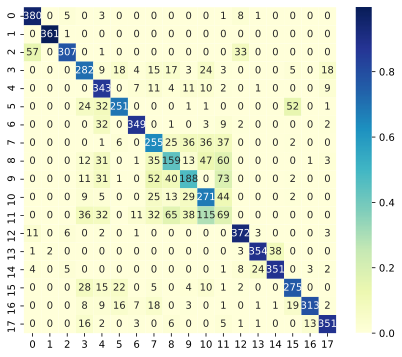

In [40]:
gb=xgb_fit()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

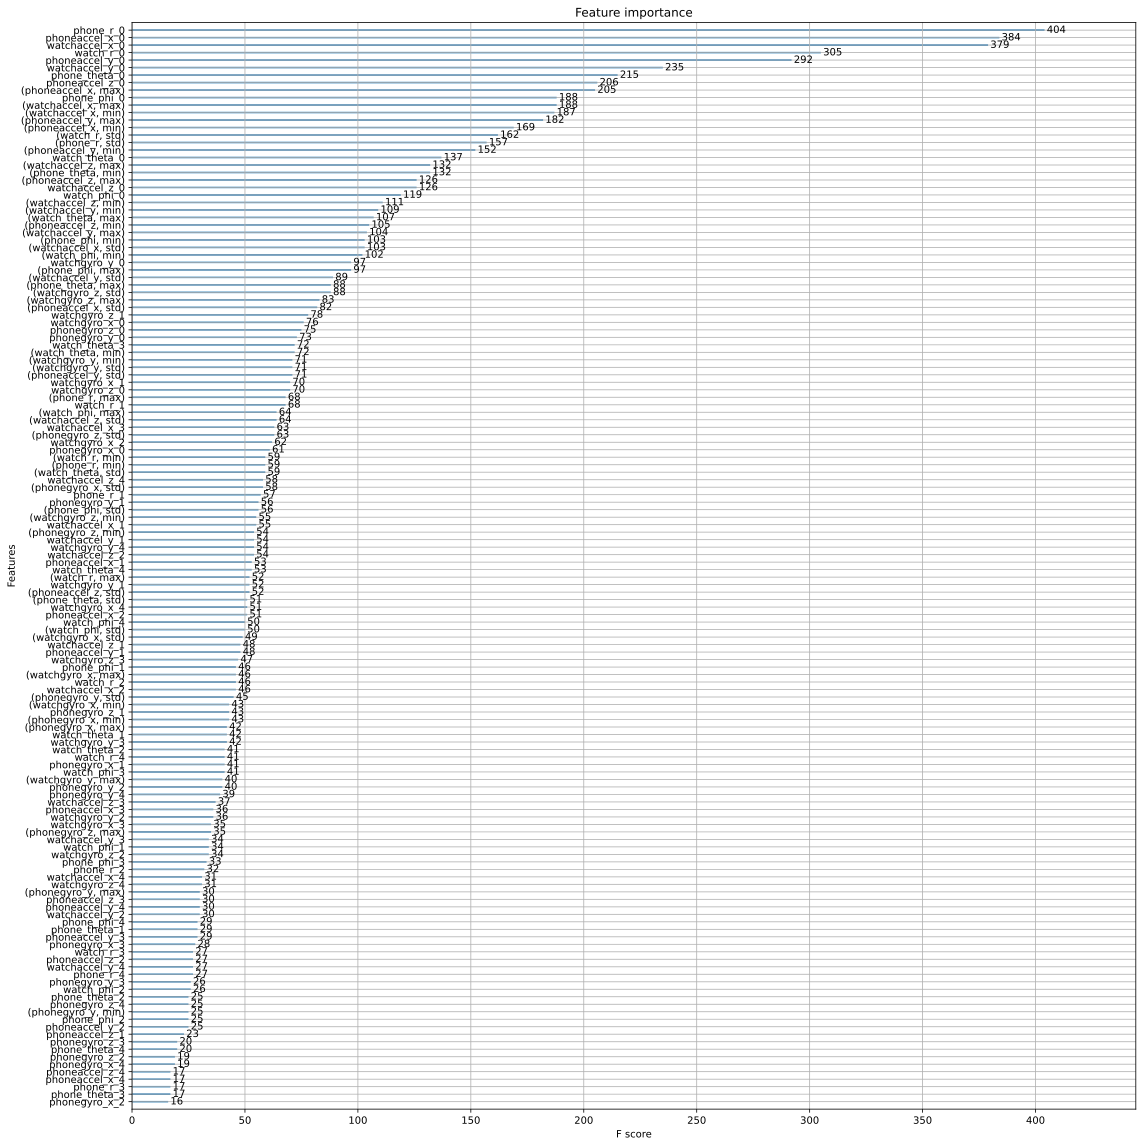

In [15]:
fig,ax=plt.subplots(figsize=(18,20))
xgb.plot_importance(gb, ax=ax)

Time to run et_fit is 6226423524 ns.
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       495
           1       0.95      0.99      0.97       450
           2       0.76      0.63      0.69       495
           3       0.72      0.68      0.70       495
           4       0.76      0.86      0.80       495
           5       0.73      0.76      0.74       450
           6       0.80      0.73      0.76       495
           7       0.46      0.61      0.53       495
           8       0.39      0.44      0.42       450
           9       0.50      0.52      0.51       495
          10       0.48      0.53      0.50       495
          11       0.30      0.11      0.16       495
          12       0.69      0.88      0.77       495
          13       0.86      0.86      0.86       495
          14       0.91      0.82      0.86       495
          15       0.68      0.75      0.71       450
          16       0.91      0.79      0.85 

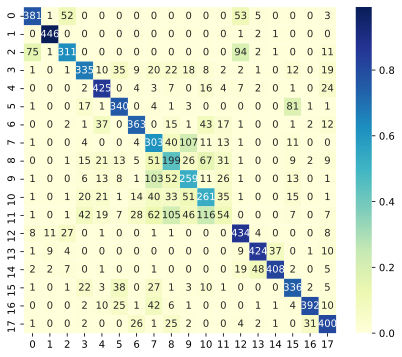

In [129]:
et = et_fit()

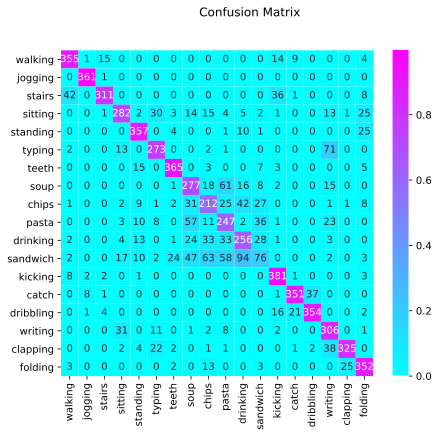

In [58]:
plt.figure(figsize=[7, 6])
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=labels, yticklabels=labels, cmap='cool')
plt.suptitle('Confusion Matrix')
plt.savefig('conf1.png',dpi=150,transparent=False)
plt.show()

<AxesSubplot:>

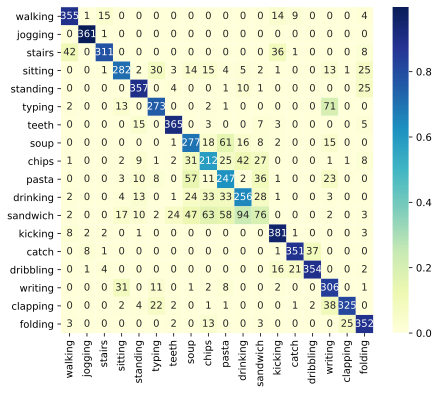

In [47]:
labels=['walking', 'jogging', 'stairs', 'sitting', 'standing', 'typing',
'teeth','soup','chips' ,'pasta' ,'drinking','sandwich','kicking' ,'catch',
'dribbling','writing' ,'clapping','folding']
result=et1  

y_pred=result.predict(X_test)
#print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=[7, 6])
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=labels, yticklabels=labels, cmap='plasma')

In [92]:
et_df=pd.DataFrame(et.feature_importances_, index=selected.columns)
et_df1=et_df.sort_values(by=0)
labels=[]
for i in et_df1.index:
    if type(i) == str:
        labels.append(i)
    else:
        labels.append(i[0]+i[1])

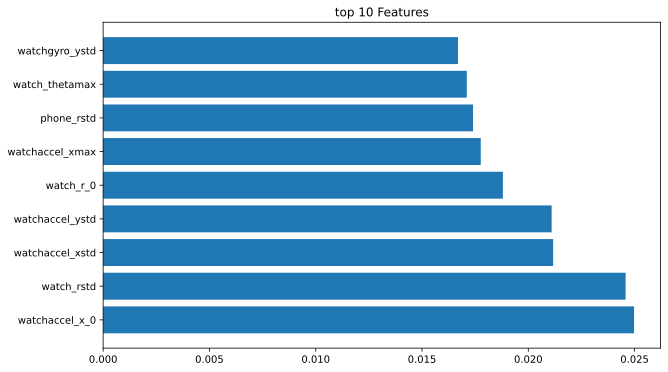

In [106]:
plt.subplots(figsize=(10,6))
plt.barh(labels[-1:-10:-1],et_df1.iloc[-1:-10:-1,0])
plt.title('top 10 Features')
plt.savefig('fint.png',dpi=150,transparent=False)

Time to run et_fit is 8261673770 ns.
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       660
           1       0.95      0.99      0.97       600
           2       0.76      0.60      0.67       660
           3       0.73      0.65      0.69       660
           4       0.73      0.86      0.79       660
           5       0.70      0.72      0.71       600
           6       0.81      0.75      0.78       660
           7       0.42      0.60      0.49       660
           8       0.36      0.42      0.39       600
           9       0.48      0.48      0.48       660
          10       0.48      0.52      0.50       660
          11       0.30      0.11      0.16       660
          12       0.66      0.85      0.74       660
          13       0.82      0.79      0.80       660
          14       0.88      0.81      0.84       660
          15       0.64      0.69      0.66       600
          16       0.90      0.80      0.84 

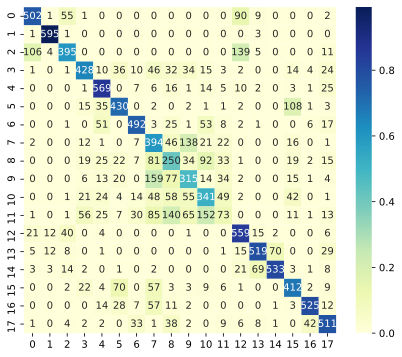

In [119]:
et = et_fit()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

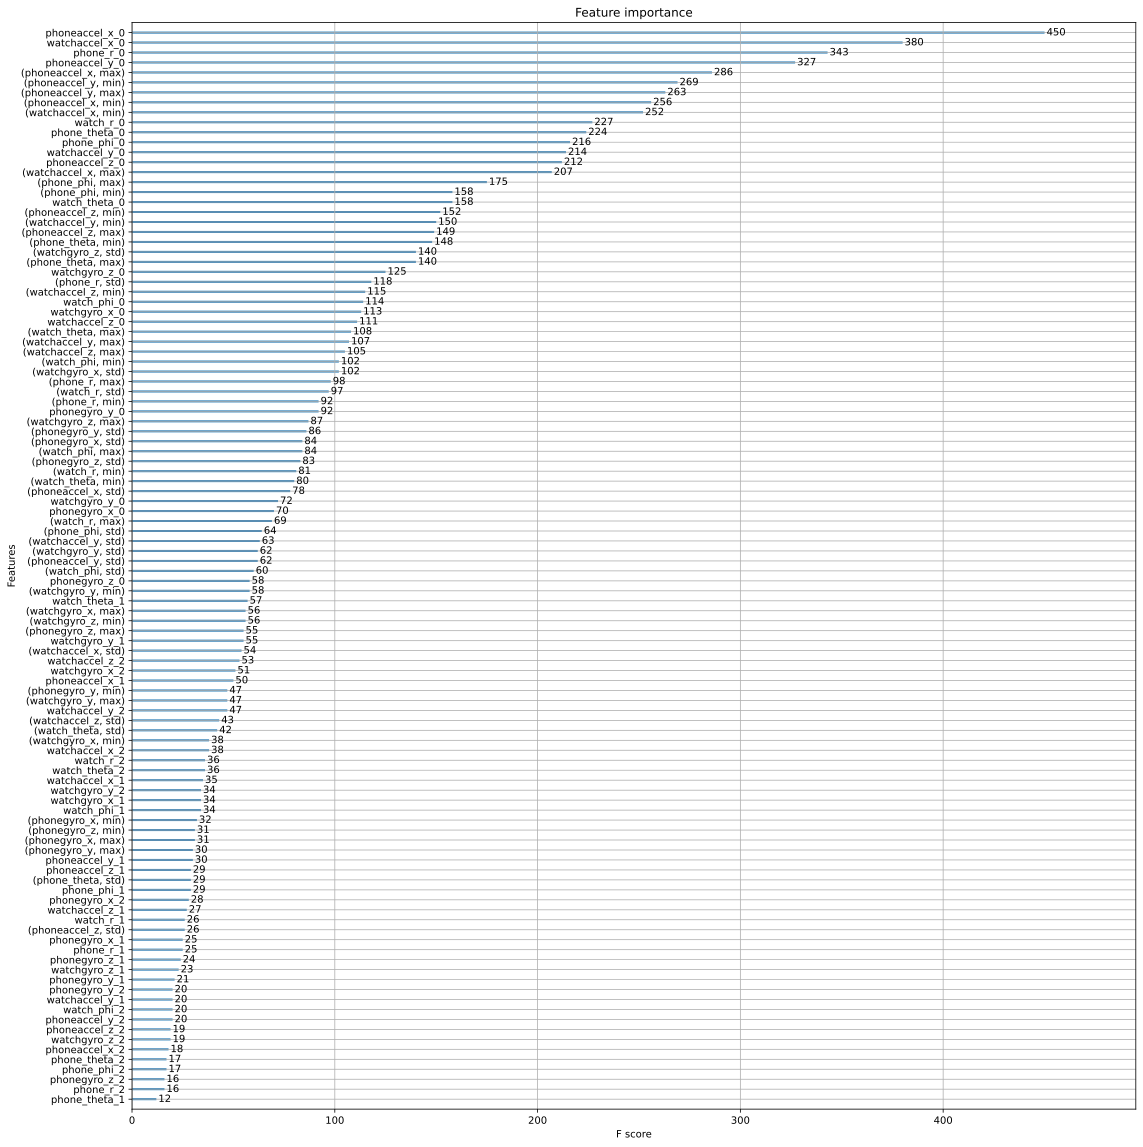

In [22]:
fig,ax=plt.subplots(figsize=(18,20))
xgb.plot_importance(gb, ax=ax)

[0]	validation_0-merror:0.26066	validation_1-merror:0.46270
[1]	validation_0-merror:0.17850	validation_1-merror:0.41550
[2]	validation_0-merror:0.13681	validation_1-merror:0.37238
[3]	validation_0-merror:0.11665	validation_1-merror:0.35023
[4]	validation_0-merror:0.09861	validation_1-merror:0.33780
[5]	validation_0-merror:0.08723	validation_1-merror:0.32964
[6]	validation_0-merror:0.07757	validation_1-merror:0.31954
[7]	validation_0-merror:0.07057	validation_1-merror:0.31721
[8]	validation_0-merror:0.06175	validation_1-merror:0.30963
[9]	validation_0-merror:0.05510	validation_1-merror:0.29876
[10]	validation_0-merror:0.04918	validation_1-merror:0.29740
[11]	validation_0-merror:0.04514	validation_1-merror:0.29176
[12]	validation_0-merror:0.04214	validation_1-merror:0.28904
[13]	validation_0-merror:0.03928	validation_1-merror:0.28710
[14]	validation_0-merror:0.03622	validation_1-merror:0.28788
[15]	validation_0-merror:0.03268	validation_1-merror:0.28594
[16]	validation_0-merror:0.03036	v

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


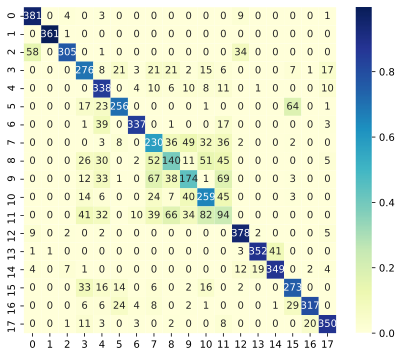

In [132]:
et = xgb_fit()

Time to run et_fit is 4775163862 ns.
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       398
           1       0.97      1.00      0.98       362
           2       0.93      0.78      0.85       398
           3       0.80      0.71      0.75       398
           4       0.85      0.90      0.87       398
           5       0.79      0.75      0.77       362
           6       0.90      0.92      0.91       398
           7       0.61      0.70      0.65       398
           8       0.57      0.59      0.58       362
           9       0.56      0.62      0.59       398
          10       0.60      0.64      0.62       398
          11       0.40      0.19      0.26       398
          12       0.83      0.96      0.89       398
          13       0.91      0.88      0.90       398
          14       0.90      0.89      0.90       398
          15       0.65      0.85      0.73       362
          16       0.92      0.82      0.87 

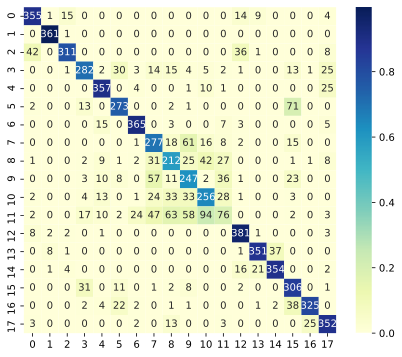

In [44]:
et1=et_fit()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

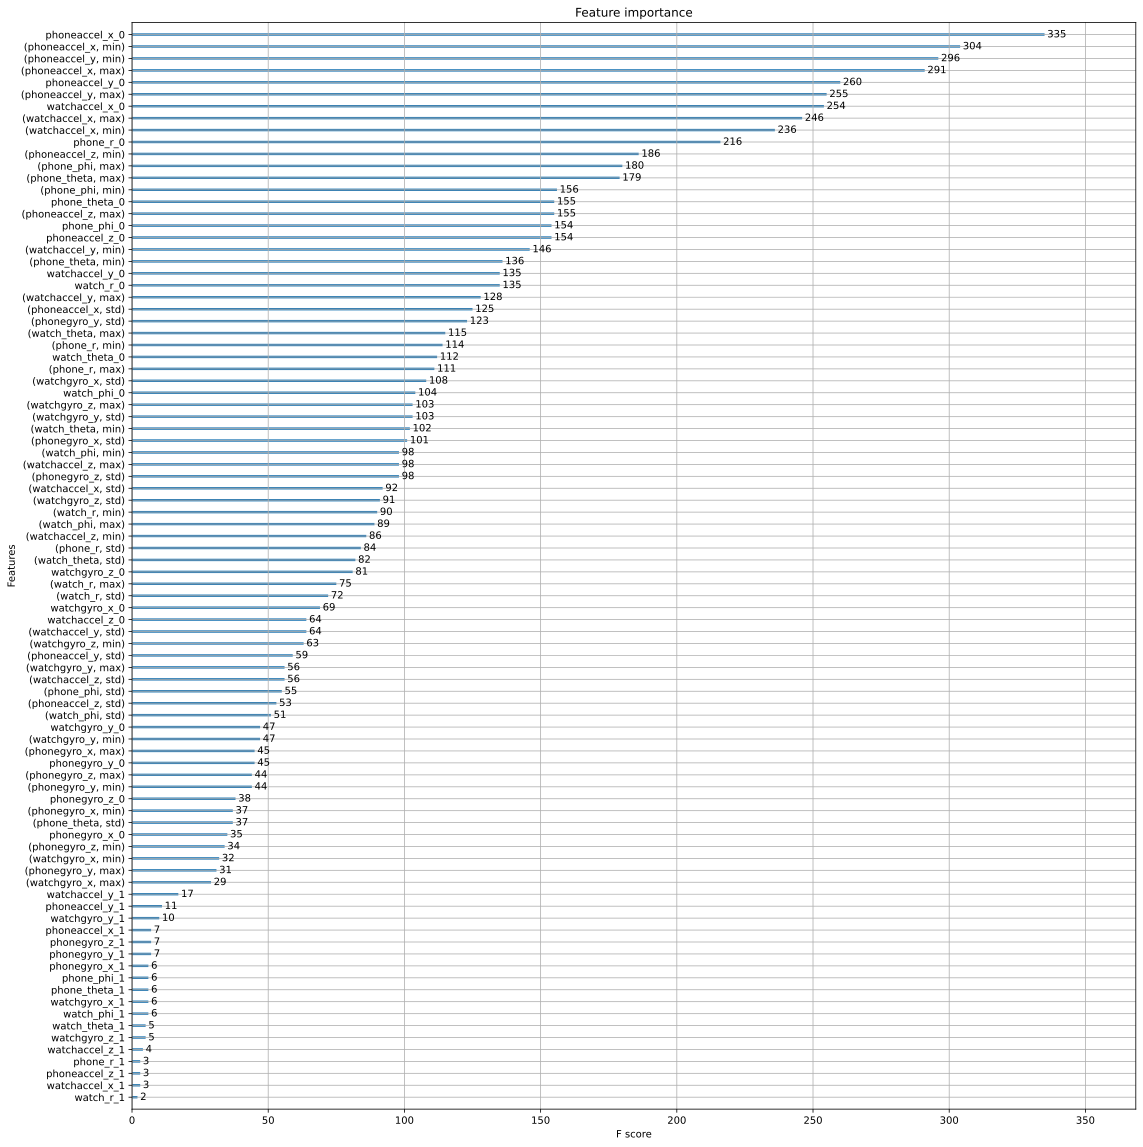

In [19]:
fig,ax=plt.subplots(figsize=(18,20))
xgb.plot_importance(xg, ax=ax)

[0]	validation_0-merror:0.28826	validation_1-merror:0.43123
[1]	validation_0-merror:0.20314	validation_1-merror:0.38947
[2]	validation_0-merror:0.17229	validation_1-merror:0.37102
[3]	validation_0-merror:0.15288	validation_1-merror:0.35645
[4]	validation_0-merror:0.13287	validation_1-merror:0.33916
[5]	validation_0-merror:0.12065	validation_1-merror:0.32984
[6]	validation_0-merror:0.10891	validation_1-merror:0.32964
[7]	validation_0-merror:0.09990	validation_1-merror:0.32187
[8]	validation_0-merror:0.09083	validation_1-merror:0.31391
[9]	validation_0-merror:0.08437	validation_1-merror:0.31158
[10]	validation_0-merror:0.07733	validation_1-merror:0.30458
[11]	validation_0-merror:0.06880	validation_1-merror:0.30284
[12]	validation_0-merror:0.06293	validation_1-merror:0.29856
[13]	validation_0-merror:0.05820	validation_1-merror:0.29332
[14]	validation_0-merror:0.05199	validation_1-merror:0.29546
[15]	validation_0-merror:0.04677	validation_1-merror:0.28885
[16]	validation_0-merror:0.04263	v

/home/lin/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


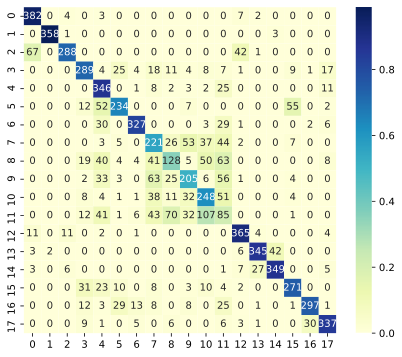

In [96]:
xg=xgb_fit()

Time to run rf_fit is 35202064125 ns.
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       398
           1       0.98      0.99      0.99       362
           2       0.92      0.78      0.84       398
           3       0.75      0.73      0.74       398
           4       0.92      0.89      0.91       398
           5       0.74      0.77      0.75       362
           6       0.95      0.97      0.96       398
           7       0.60      0.73      0.66       398
           8       0.58      0.65      0.61       362
           9       0.64      0.70      0.67       398
          10       0.63      0.65      0.64       398
          11       0.46      0.23      0.31       398
          12       0.83      0.93      0.88       398
          13       0.93      0.87      0.90       398
          14       0.90      0.90      0.90       398
          15       0.66      0.73      0.70       362
          16       0.89      0.81      0.85

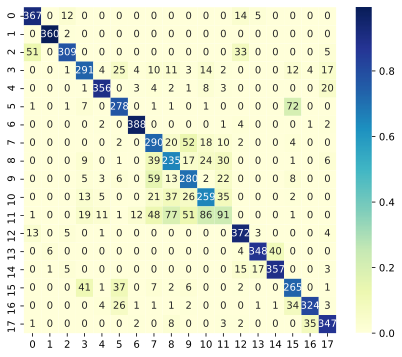

In [31]:
rf1=rf_fit()

In [32]:
#pickle.dump(rf1,open('rf.p','wb'))

In [15]:
et1=pickle.load(open('et.p','rb'))

EOFError: Ran out of input

In [ ]:
et.feature_importances_

In [43]:
@c_report
@timing
def rf_fit():
    rf=RandomForestClassifier(n_estimators=180,max_depth = 35)
    rf.fit(X_train,y_train)   
    return rf


@c_report
@timing
def et_fit():
    et=ExtraTreesClassifier(n_estimators=150,max_depth = 30)
    et.fit(X_train,y_train)   
    return et

In [ ]:
gkf=GroupKFold(n_splits=5)

In [ ]:
scores1 = cross_validate(et,X_train, y_train, cv=gkf, groups=X_train.index.get_level_values(0),
                        scoring='accuracy')
scores1

In [ ]:
scores = cross_validate(rf,X_train, y_train, cv=gkf, groups=X_train.index.get_level_values(0),
                        scoring='accuracy')
scores

In [ ]:
F Q, typing writing versus , typing and sitting,
H J soup versus pasta
I K chip drinking
D F sitting typing,
A C walking stairs  
A M walking kicking
C M stair kicking 

In [131]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 40530 entries, ('00', 0, 0) to ('50', 17, 44)
Data columns (total 90 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (phoneaccel_x, std)  40530 non-null  float64
 1   (phoneaccel_x, min)  40530 non-null  float32
 2   (phoneaccel_x, max)  40530 non-null  float32
 3   (phoneaccel_y, std)  40530 non-null  float64
 4   (phoneaccel_y, min)  40530 non-null  float32
 5   (phoneaccel_y, max)  40530 non-null  float32
 6   (phoneaccel_z, std)  40530 non-null  float64
 7   (phoneaccel_z, min)  40530 non-null  float32
 8   (phoneaccel_z, max)  40530 non-null  float32
 9   (phone_r, std)       40530 non-null  float64
 10  (phone_r, min)       40530 non-null  float32
 11  (phone_r, max)       40530 non-null  float32
 12  (phone_phi, std)     40530 non-null  float64
 13  (phone_phi, min)     40530 non-null  float32
 14  (phone_phi, max)     40530 non-null  float32
 15  (phone_theta, st